In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scienceplots
%matplotlib inline
from seaborn import displot, histplot
plt.style.use(['seaborn-v0_8-paper'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft
from scipy import stats

In [8]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

# report sample size
len(lyft_conflict_list1), len(lyft_conflict_list2)

(859, 886)

In [9]:
# convert the type to latest conflict object
conflict_list1 = list()
for c_index, c in enumerate(lyft_conflict_list1):
    # print(c_index)
    conflict_list1.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=1,
    ))
assert len(conflict_list1) == len(lyft_conflict_list1)

conflict_list2 = list()
for c_index, c in enumerate(lyft_conflict_list2):
    # print(c_index)
    conflict_list2.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=2,
    ))
assert len(conflict_list2) == len(lyft_conflict_list2)

conflict_list = conflict_list1 + conflict_list2

len(conflict_list1), len(conflict_list2)

(859, 886)

In [10]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    # "minTTC",
    "leader_avg_v",
    "follower_avg_v",
    "leader_conflict_v",
    "follower_conflict_v",
]

# generate each rows in the dataframe
conflict_rows_in_df = list()

for index, conflict in enumerate(conflict_list):
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        # conflict.minimum_TTC,
        conflict.leader_average_speed,
        conflict.follower_average_speed,
        conflict.leader_conflict_speed,
        conflict.follower_conflict_speed,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()
# conflict_df.to_csv("./outputs/lyft_heatmap_speeds_PET.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Conflict type        1745 non-null   object 
 1   Vehicle order        1745 non-null   object 
 2   PET                  1745 non-null   float64
 3   leader_avg_v         1745 non-null   float64
 4   follower_avg_v       1745 non-null   float64
 5   leader_conflict_v    1737 non-null   float64
 6   follower_conflict_v  1739 non-null   float64
dtypes: float64(5), object(2)
memory usage: 109.1+ KB


In [11]:
conflict_df = conflict_df.dropna()

In [12]:
conflict_df.to_csv("./outputs/trb/lyft_follower_speed.csv", index=False)

In [13]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['follower_conflict_v'].mean()

Conflict type  Vehicle order
Cross          AV-HV            6.396116
               HV-AV            5.236043
               HV-HV            5.938488
Merge          AV-HV            6.417640
               HV-AV            6.422123
               HV-HV            6.281468
Name: follower_conflict_v, dtype: float64

In [14]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['follower_conflict_v'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.413395
               HV-AV            1.516403
               HV-HV            1.594706
Merge          AV-HV            1.753556
               HV-AV            0.988942
               HV-HV            1.653253
Name: follower_conflict_v, dtype: float64

In [15]:
HVHV = conflict_df[conflict_df["Vehicle order"] == "HV-HV"]
AVHV = conflict_df[conflict_df["Vehicle order"] == "AV-HV"]
HVAV = conflict_df[conflict_df["Vehicle order"] == "HV-AV"]

cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

### ANOVA

In [25]:
stats.f_oneway(HVHV_merge.follower_conflict_v, HVAV_merge.follower_conflict_v, AVHV_merge.follower_conflict_v)

F_onewayResult(statistic=0.9188324622777552, pvalue=0.399284869032425)

In [26]:
stats.f_oneway(HVHV_cross.follower_conflict_v, HVAV_cross.follower_conflict_v, AVHV_cross.follower_conflict_v)

F_onewayResult(statistic=11.380712182364407, pvalue=1.4069325897661786e-05)

### T-test

In [11]:
stats.ttest_ind(HVHV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

Ttest_indResult(statistic=-2.146987707417906, pvalue=0.03226141934819153)

In [9]:
stats.ttest_ind(HVHV_cross['follower_conflict_v'], HVAV_cross['follower_conflict_v'])

Ttest_indResult(statistic=3.8659609300497455, pvalue=0.0001240480514933217)

In [21]:
# HVAV AVHV | Cross
stats.ttest_ind(HVAV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

Ttest_indResult(statistic=-4.773875004885774, pvalue=4.233079360815363e-06)

In [12]:
stats.ttest_ind(HVHV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

Ttest_indResult(statistic=-0.9151254543884306, pvalue=0.3603624750466351)

In [10]:
stats.ttest_ind(HVHV_merge['follower_conflict_v'], HVAV_merge['follower_conflict_v'])

Ttest_indResult(statistic=-1.1246892494942418, pvalue=0.26099839438570355)

In [22]:
# HVAV AVHV | Merge
stats.ttest_ind(HVAV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

Ttest_indResult(statistic=0.029754878365665458, pvalue=0.9762801057891701)

### Mann-Whitney U Test

In [15]:
stats.mannwhitneyu(HVHV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

MannwhitneyuResult(statistic=11137.0, pvalue=0.007663161082179495)

In [13]:
stats.mannwhitneyu(HVHV_cross['follower_conflict_v'], HVAV_cross['follower_conflict_v'])

MannwhitneyuResult(statistic=28169.0, pvalue=4.286200194716561e-08)

In [23]:
# new
stats.mannwhitneyu(HVAV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

MannwhitneyuResult(statistic=1384.0, pvalue=9.371804002184136e-08)

In [16]:
stats.mannwhitneyu(HVHV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

MannwhitneyuResult(statistic=53651.0, pvalue=0.08897420336242243)

In [14]:
stats.mannwhitneyu(HVHV_merge['follower_conflict_v'], HVAV_merge['follower_conflict_v'])

MannwhitneyuResult(statistic=68439.0, pvalue=0.0825096679911828)

In [24]:
# new
stats.mannwhitneyu(HVAV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

MannwhitneyuResult(statistic=13985.0, pvalue=0.7688254782383931)

<Figure size 200x200 with 0 Axes>

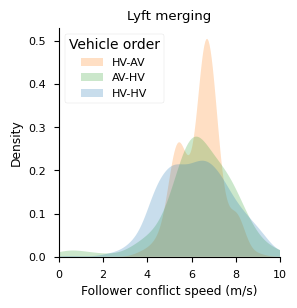

In [17]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

FIGURE_WIDTH, FIGURE_HEIGHT = 2, 2
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
g = displot(
    data=conflict_df[conflict_df["Conflict type"] == "Merge"],
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
    legend=False
)
g.axes[0,0].set_xlabel("Follower conflict speed (m/s)")
plt.xlim([0,10])
plt.title("Lyft merging")
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order", loc=2)
plt.savefig(f"./outputs/trb/speed_lyft_merge.png", dpi=300, bbox_inches="tight")

<Figure size 200x200 with 0 Axes>

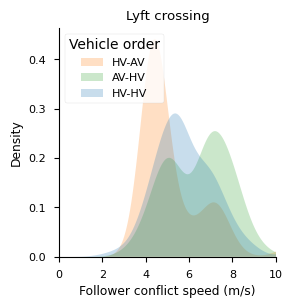

In [18]:
FIGURE_WIDTH, FIGURE_HEIGHT = 2, 2
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

conflictType = "Cross"
g = displot(
    data=conflict_df[conflict_df["Conflict type"] == "Cross"],
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
    legend=False
)
g.axes[0,0].set_xlabel("Follower conflict speed (m/s)")
plt.xlim([0,10])
plt.title("Lyft crossing")
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order", loc=2)
plt.savefig(f"./outputs/trb/speed_lyft_cross.png", dpi=300, bbox_inches="tight")

<Figure size 200x200 with 0 Axes>

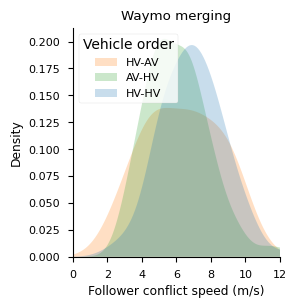

In [31]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

FIGURE_WIDTH, FIGURE_HEIGHT = 2, 2
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

df = pd.read_csv("./outputs/plots/waymo_f_conflict_speed_merge.csv")
g = displot(
    data=df,
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
    legend=False
)
g.axes[0,0].set_xlabel("Follower conflict speed (m/s)")
plt.xlim([0,12])
plt.title("Waymo merging")
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order", loc=2)
plt.savefig(f"./outputs/plots/speed_waymo_merge.png", dpi=300, bbox_inches="tight")

<Figure size 200x200 with 0 Axes>

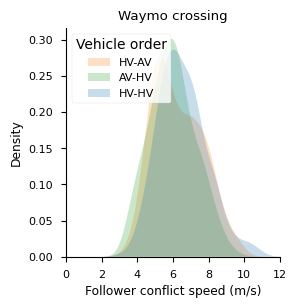

In [33]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

FIGURE_WIDTH, FIGURE_HEIGHT = 2, 2
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

df = pd.read_csv("./outputs/plots/waymo_f_conflict_speed_cross.csv")
g = displot(
    data=df,
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
    legend=False
)
g.axes[0,0].set_xlabel("Follower conflict speed (m/s)")
plt.xlim([0,12])
plt.title("Waymo crossing")
plt.legend(["HV-AV", "AV-HV", "HV-HV"], loc=2)
plt.savefig(f"./outputs/plots/speed_waymo_cross.png", dpi=300, bbox_inches="tight")

## Conflict speed VS PET

### Follower

<Figure size 900x300 with 0 Axes>

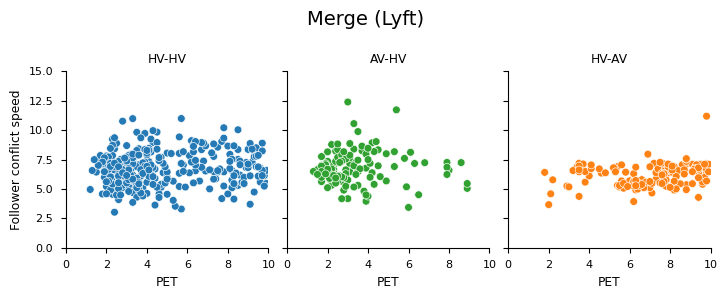

In [24]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
conflictType = "Merge"

g = relplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType], 
    x="PET",
    y="follower_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle(f"{conflictType} (Lyft)", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, PET_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig(f"./outputs/plots/lyft_scatterplot_follower_conflict_speed_PET_{conflictType}.png", dpi=300, bbox_inches="tight")

<Figure size 900x300 with 0 Axes>

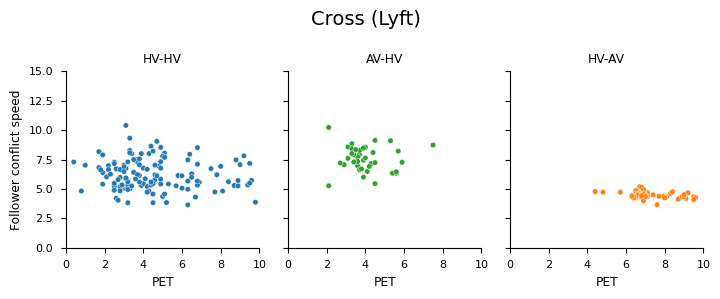

In [26]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
conflictType = "Cross"

g = relplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType], 
    x="PET",
    y="follower_conflict_v",
    size=0.1,
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle(f"{conflictType} (Lyft)", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, PET_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig(f"./outputs/plots/lyft_scatterplot_follower_conflict_speed_PET_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Leader

<Figure size 900x300 with 0 Axes>

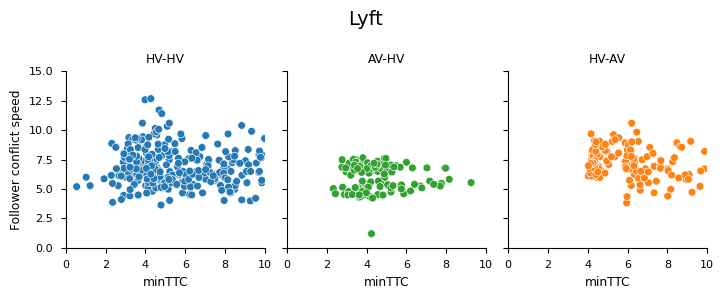

In [5]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="leader_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Lyft", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/lyft_scatterplot_leader_conflictspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

## Average speed VS minTTC

### Follower

<Figure size 900x300 with 0 Axes>

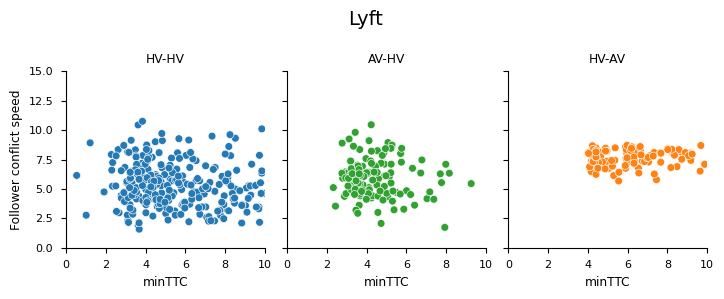

In [6]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="follower_avg_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Lyft", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/lyft_scatterplot_follower_avgspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

### Leader

<Figure size 900x300 with 0 Axes>

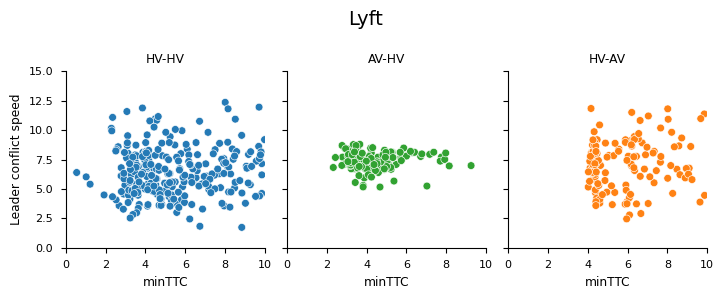

In [7]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="leader_avg_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Lyft", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Leader conflict speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/lyft_scatterplot_leader_avgspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")